**Business Problem:**

The grocery retail chain wants to improve how it targets and engages customers. Although it collects detailed information on demographics, household structure, spending habits, product preferences, and campaign responses, this data is not being used to segment customers effectively.

The goal of this project is to **analyze the customer dataset to uncover meaningful customer segments**. By grouping customers based on their behavior and characteristics, the retailer can design personalized marketing strategies, focus promotions on the right audiences,and increase overall revenue

The grocery dataset is **categorized into four main attributes — People, Place, Product, and Promotion**— comprising a total of 29 columns. Below is a visual representation, where each box shows a category and the variables it contains:

<center>
  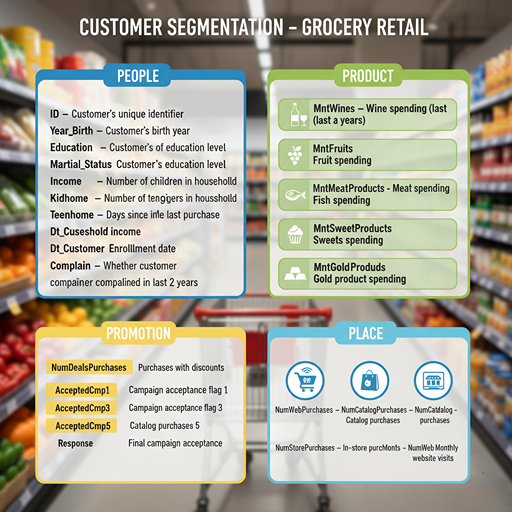  </center>


**Project Workflow**

A. **Data Preparation**
1. Import the dataset and review its structure
2. Clean missing or inconsistent values
3. Detect and remove outliers
4. Feature Engineering

B. **Exploratory Data Analysis**
1. Univariate Analysis
2. Looking for correlations

C. **Clustering**
1. Scale numerical features to prepare for clustering
2. Apply K-Means clustering with multiple values of k

D. **Silhouette score**
1. Compute silhouette scores to evaluate cluster quality
2. Select the optimal number of clusters based on performance

E. **Analysis**
1. Analyze each cluster and translate findings into actionable business recommendations

## Data preparation

#### Step 1: Import the dataset and review its structure

In [35]:
# Load the libraries
%matplotlib inline

import os

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

from IPython.display import display, Markdown
import io

# Warning settings
warnings.filterwarnings("ignore")

# Set the theme for visualization
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

# Pandas display settings
pd.set_option("display.max_colwidth", None)

In [60]:
# Load Dataset & Schema

# File paths
DATA_PATH = "./Data/marketing_campaign.csv"
SCHEMA_PATH = "./Data/customer_personality_segmentation_schema.csv"

# Validate file paths
if not os.path.isfile(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at: {DATA_PATH}")

if not os.path.isfile(SCHEMA_PATH):
    raise FileNotFoundError(f"Schema file not found at: {SCHEMA_PATH}")

# Load dataset
data_raw = pd.read_csv(DATA_PATH, sep="\t", encoding="utf-8")
schema_raw = pd.read_csv(SCHEMA_PATH, encoding="Windows-1252")

# Create working copies
data = data_raw.copy()
schema = schema_raw.copy()

# Set index for faster reference
if "Fields" in schema.columns:
    schema = schema.set_index("Fields").dropna()
else:
    raise KeyError("'Fields' column missing in schema file.")

Show the first rows to check if the file was correctly loaded

In [37]:
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


Understanding the columns and its description.

There are 29 columns divided into the following categories:



In [38]:
def dataset_summary(df: pd.DataFrame, schema: pd.DataFrame) -> None:

    #Generates a structured overview of the dataset, including

    display(Markdown("## Dataset Overview"))

    display(Markdown("### Column Description, Data Types & Null Values"))
    col_summary = pd.DataFrame({
        "Dtype": df.dtypes.astype(str),
        "Null_Count": df.isnull().sum(),
        "Null_%": round((df.isnull().sum() / len(df)) * 100, 2)
    })

    if schema is not None:
        schema_copy = schema.copy()
        col_summary = schema_copy.join(col_summary, how="left")

    display(col_summary)

    # Summary Statistics
    display(Markdown("### Summary Statistics"))
    numeric_df = df.select_dtypes(include=np.number)
    if numeric_df.shape[1] > 0:
        display(numeric_df.describe().T)
    else:
        display(Markdown("No numerical columns available for summary statistics"))

dataset_summary(data, schema)

## Dataset Overview

### Column Description, Data Types & Null Values

,Description,Dtype,Null_Count,Null_%
Fields,,,,
NumWebVisitsMonth,Number of visits to company’s website in the last month,int64,0,0.00
Teenhome,Number of teenagers in customer's household,int64,0,0.00
NumDealsPurchases,Number of purchases made with a discount,int64,0,0.00
NumCatalogPurchases,Number of purchases made using a catalogue,int64,0,0.00
NumWebPurchases,Number of purchases made through the company’s website,int64,0,0.00
NumStorePurchases,Number of purchases made directly in stores,int64,0,0.00
Recency,Number of days since customer's last purchase,int64,0,0.00
Kidhome,Number of children in customer's household,int64,0,0.00
Dt_Customer,Date of customer's enrollment with the company,object,0,0.00


### Summary Statistics

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2216.0,52247.251354,25173.076661,1730.0,35303.00,51381.5,68522.00,666666.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0


**Observations:**
* Income contains a small number of missing values; investigate whether these occur due to data entry issues or specific customer segments.
* Dt_Customer is stored as an object, convert it to a proper datetime type.
* Education and Marital_Status contain multiple unique labels; review and converting to categorical types
* Create new columns in the feature engineering section such as Age from Year_Birth to improve interpretability in later analysis
* Visualize all numeric variables to examine distributions, detect outliers, and identify skewness because clustering alogithms can be sensitive to outliers and distributions

### Step 2: Data Cleaning — Checking Missing Values

In [39]:
num_values = data['Income'].isna().sum()
total_observations = data.shape[0]
print(f'These {num_values} rows represents {100*num_values/total_observations:.2f}% of the total dataset')

These 24 rows represents 1.07% of the total dataset


## Investigating Why Income Data Is Missing

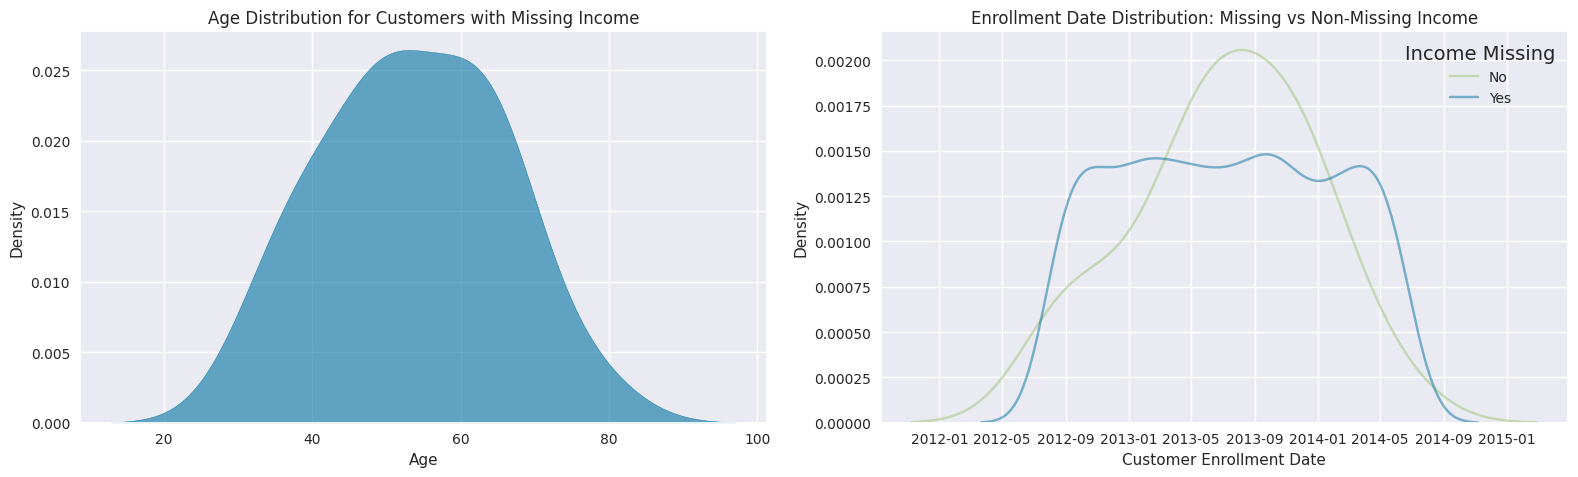

In [40]:
# Investigating Causes Behind Missing Income Values

display(Markdown("## Investigating Why Income Data Is Missing"))

# Hypothesis:
# Missing income may be correlated with:
#   - Certain age groups (very young/old dependents)
#   - Early customers whose income was never recorded - system errors

# Age Calculation
DATA_PUBLISH_YEAR = 2021

data["Age"] = DATA_PUBLISH_YEAR - data["Year_Birth"]

# Ensure Dt_Customer is datetime
if not np.issubdtype(data["Dt_Customer"].dtype, np.datetime64):
    data["Dt_Customer"] = pd.to_datetime(
        data["Dt_Customer"], dayfirst=True, errors="coerce"
    )

# Plot Age Distribution
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(
    data=data[data["Income"].isna()],
    x="Age",
    fill=True,
    alpha=0.6
)
plt.title("Age Distribution for Customers with Missing Income")
plt.xlabel("Age")
plt.ylabel("Density")

# Plot Enrollment Timing (Missing vs Not Missing)
plt.subplot(1, 2, 2)
sns.kdeplot(
    data=data,
    x="Dt_Customer",
    hue=data["Income"].isna(),
    common_norm=False,
    alpha=0.5
)
plt.title("Enrollment Date Distribution: Missing vs Non-Missing Income")
plt.xlabel("Customer Enrollment Date")
plt.ylabel("Density")
plt.legend(title="Income Missing", labels=["No", "Yes"])

plt.tight_layout()
plt.show()


**Observtion**:
Missing‐income customers are spread across all ages and enrollment dates, suggesting the issue is not demographic. This likely reflects data entry or business-related gaps and should be confirmed with the team

**Action**:
For now, drop records with missing income, and revisit if needed. Alternatively, consider imputing income using averages from similar demographic groups (matching by age, location, or education)

In [41]:
dataframe_clean = data.dropna().copy()

In [42]:
# Review unique values in categorical fields
print("Unique Education values:", dataframe_clean["Education"].unique())
print("Unique Marital Status values:", dataframe_clean["Marital_Status"].unique())

Unique Education values: ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
Unique Marital Status values: ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']


In [43]:
# Simplify Education and Marital_Status categories.
# In this problem, this granularity might not be so important, so I will simplifly these to values that get the same idea

education_map = {
    'Graduation': 1, # Higher Education
    'PhD': 2, # Basic Education
    'Master': 2, # Advanced Education
    'Basic': 0, # Advanced Education
    '2n Cycle': 0 # Basic Education
}

marital_status_map = {
    "Single": "Alone",
    "Together": "Pair",
    "Married": "Pair",
    "Divorced": "Alone",
    "Widow": "Alone",
    "Absurd": "Alone",
    "Alone": "Alone",
    "YOLO": "Alone",
}

marital_status_dict = {'Alone': 0,
                       'Pair': 1}

dataframe_clean["Education_Level"] = dataframe_clean["Education"].map(education_map)
dataframe_clean["Marital_Status_new"] = dataframe_clean["Marital_Status"].map(marital_status_map)

# Convert selected columns to categorical type
dataframe_clean[["Education", "Marital_Status"]] = dataframe_clean[["Education", "Marital_Status"]].astype("category")

## Feature Engineering

#### Create several new features to enhance the dataset:

1. Age – calculated using the customer’s birth year and the most recent date in the dataset (serving as the reference “current” date).

2. Children – total number of dependents, combining Kidhome and Teenhome.

3. TotalMembers – household size, derived from marital status and number of children.

4. TotalSpent – total monetary value spent across all product categories.

5. NumberMonthsCustomer - total months each customer has been associated with the business, based on their enrollment date.

In [44]:


# Determine the most recent year in the dataset to calculate age
current_year = dataframe_clean['Dt_Customer'].max().year
current_date = dataframe_clean['Dt_Customer'].max()

# Age column
dataframe_clean['Age'] = current_year - dataframe_clean['Year_Birth']

# Children column
dataframe_clean['Children'] = dataframe_clean['Kidhome'] + dataframe_clean['Teenhome']

# TotalMembers column (1 for Alone, 2 for Pair)
household_size_map = {'Alone': 1, 'Pair': 2}
dataframe_clean['TotalMembers'] = dataframe_clean['Children'] + dataframe_clean['Marital_Status_new'].map(household_size_map)

# TotalSpent Column
spent_cols = [
    'MntWines', 'MntFruits', 'MntMeatProducts',
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'
]
dataframe_clean['TotalSpent'] = dataframe_clean[spent_cols].sum(axis=1)

# Number of months the customer is with the company
def month_diff(later_date, earlier_date):
    return 12 * (later_date.year - earlier_date.year) + (later_date.month - earlier_date.month)

dataframe_clean['n_months_customer'] = dataframe_clean['Dt_Customer'].apply(
    lambda start_date: month_diff(current_date, start_date)
)

# is_pair column
dataframe_clean['is_pair'] = dataframe_clean['Marital_Status_new'].map({'Alone': 0, 'Pair': 1})


In [45]:
dataframe_clean.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,Z_CostContact,Z_Revenue,Response,Age,Education_Level,Children,TotalMembers,TotalSpent,n_months_customer,is_pair
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.0,2216.0,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,5588.353339,1968.820397,52247.251354,0.441787,0.505415,2013-07-10 11:29:27.509025280,49.012635,305.091606,26.356047,166.995939,...,3.0,11.0,0.150271,45.179603,1.267148,0.947202,2.592509,607.075361,11.193592,0.645307
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,2012-07-30 00:00:00,0.000000,0.000000,0.000000,0.000000,...,3.0,11.0,0.000000,18.000000,0.000000,0.000000,1.000000,5.000000,0.000000,0.000000
25%,2814.750000,1959.000000,35303.000000,0.000000,0.000000,2013-01-16 00:00:00,24.000000,24.000000,2.000000,16.000000,...,3.0,11.0,0.000000,37.000000,1.000000,0.000000,2.000000,69.000000,6.000000,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,2013-07-08 12:00:00,49.000000,174.500000,8.000000,68.000000,...,3.0,11.0,0.000000,44.000000,1.000000,1.000000,3.000000,396.500000,11.000000,1.000000
75%,8421.750000,1977.000000,68522.000000,1.000000,1.000000,2013-12-31 00:00:00,74.000000,505.000000,33.000000,232.250000,...,3.0,11.0,0.000000,55.000000,2.000000,1.000000,3.000000,1048.000000,17.000000,1.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,2014-06-29 00:00:00,99.000000,1493.000000,199.000000,1725.000000,...,3.0,11.0,1.000000,121.000000,2.000000,3.000000,5.000000,2525.000000,23.000000,1.000000
std,3249.376275,11.985554,25173.076661,0.536896,0.544181,NaN,28.948352,337.327920,39.793917,224.283273,...,0.0,0.0,0.357417,11.985554,0.652084,0.749062,0.905722,602.900476,6.650445,0.478528


Observation:
1. Year_Birth, Income, and Age have clear outliers. Some ages look unrealistically high, and some incomes are much higher than normal. We will plot these columns to understand the issue and decide how to fix it.


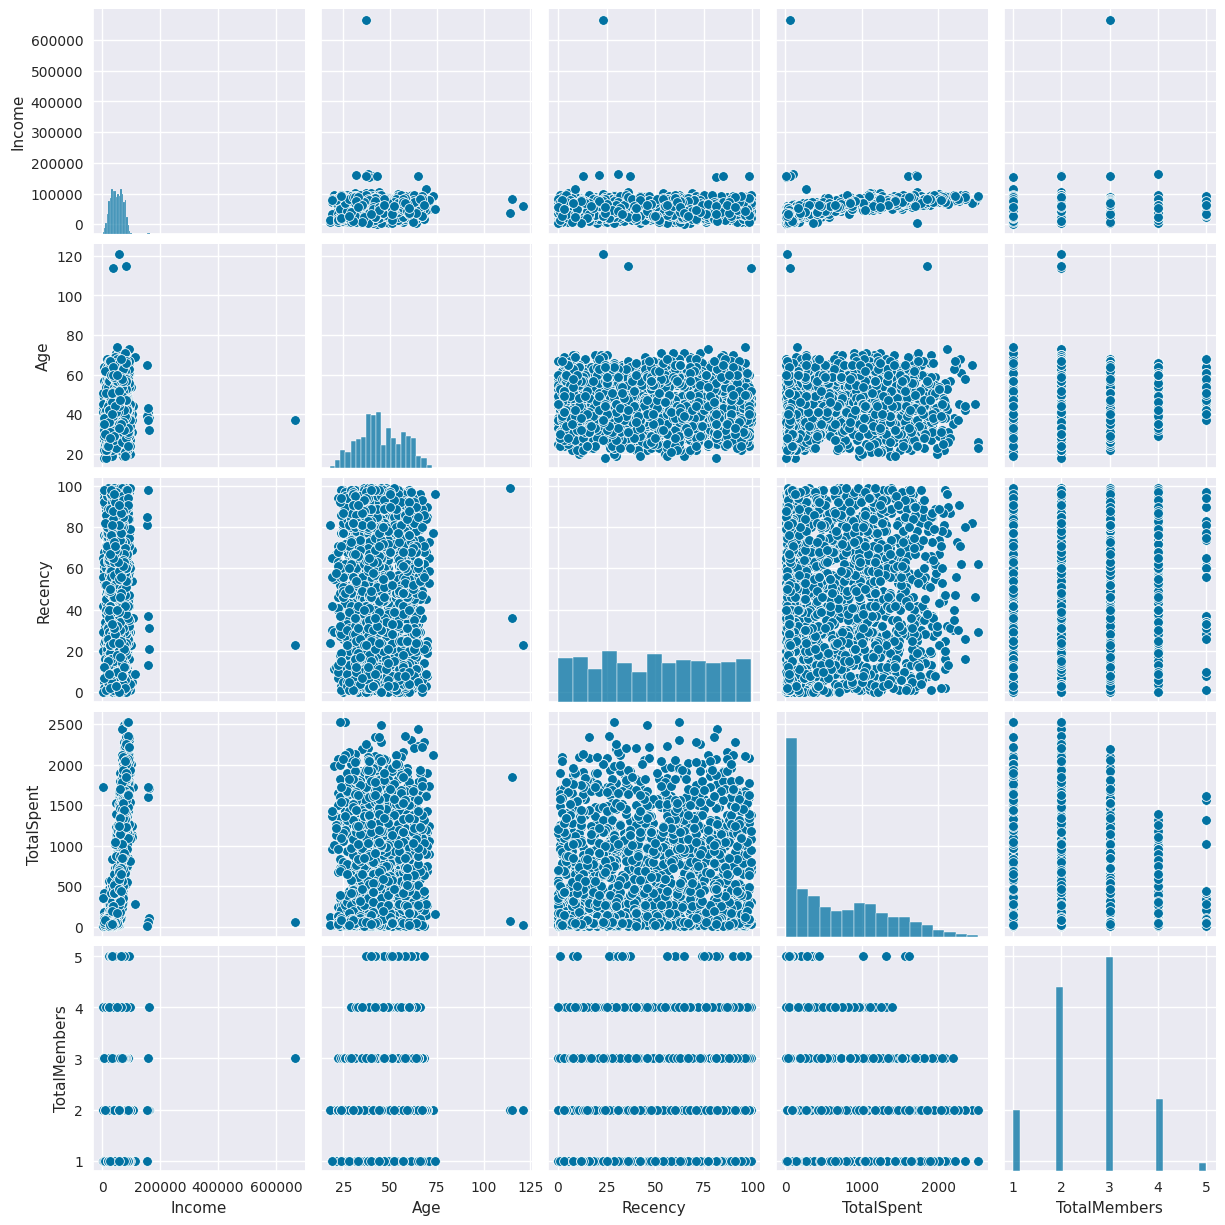

In [46]:
sns.color_palette("Paired")
columns_to_plot = ['Income', 'Age', 'Recency', 'TotalSpent', 'TotalMembers']
sns.pairplot(dataframe_clean[columns_to_plot])


**Observation:**

1. Income and Age clearly contain outliers. There are different ways to handle them, but for this project we will remove extreme values by applying a reasonable threshold.



In [47]:
# Age less than 90
dataframe_clean = dataframe_clean[dataframe_clean['Age'] < 90]

# Income less than 300k
dataframe_clean = dataframe_clean[dataframe_clean['Income'] < 300000]

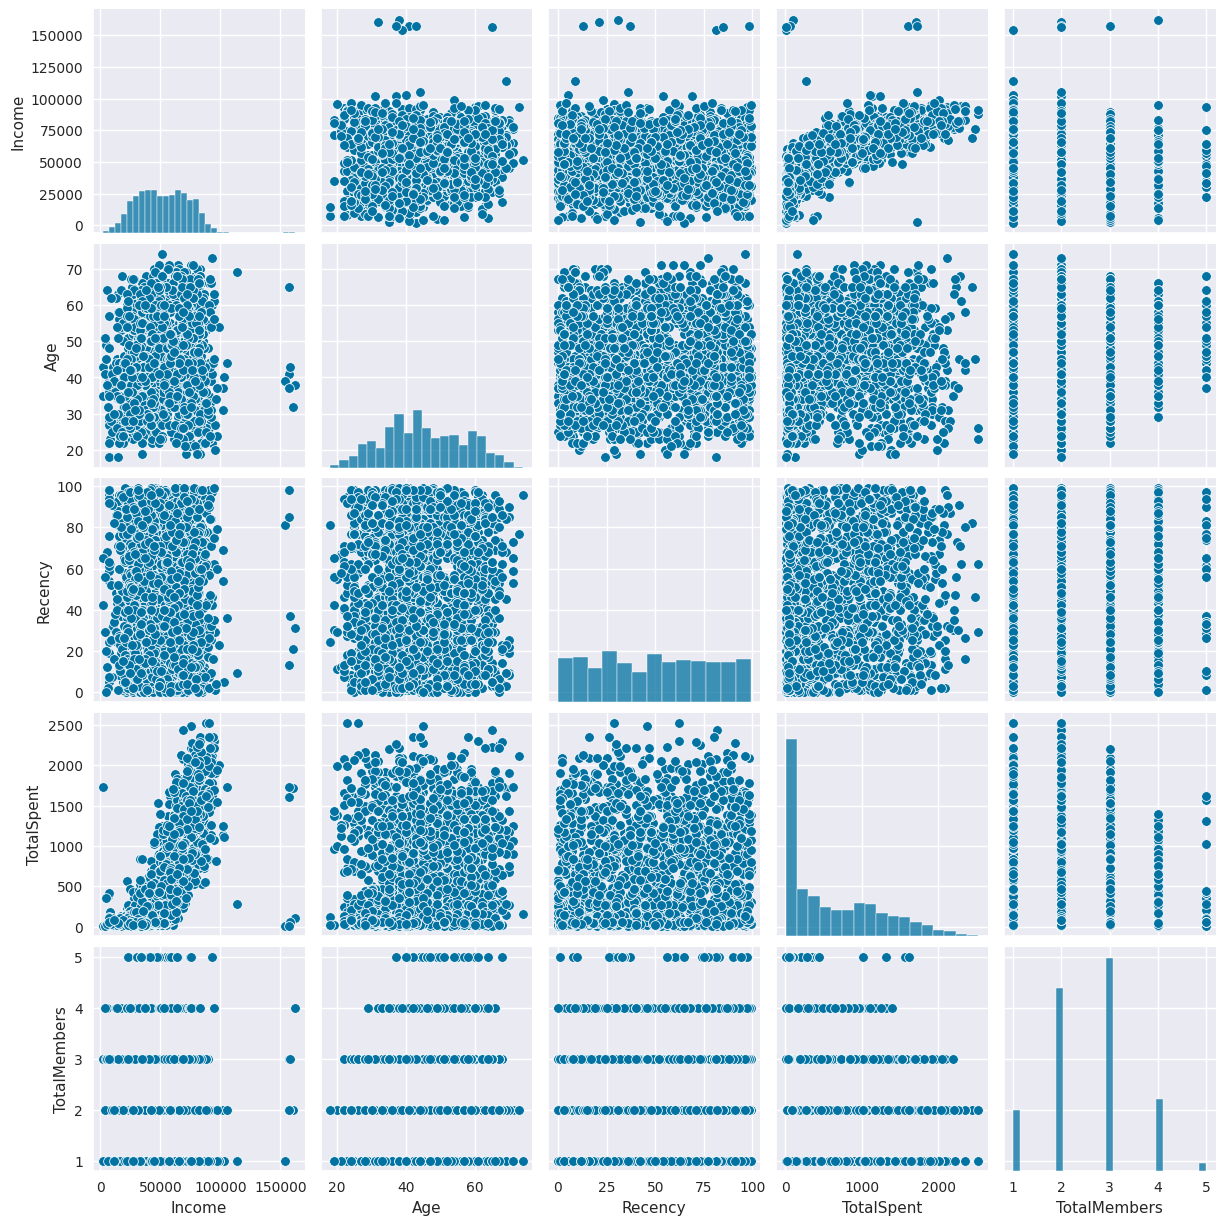

In [48]:
sns.color_palette("Paired")
columns_to_plot = ['Income', 'Age', 'Recency', 'TotalSpent', 'TotalMembers']
# dataframe_clean[columns_to_plot]
sns.pairplot(dataframe_clean[columns_to_plot])

Select only the important features and renaming them

In [49]:
columns = ['Age',
           'Education_Level',
           'Children',
           'is_pair',
           'TotalMembers',
           'Income',
           'n_months_customer',
           'Recency',
           'MntWines',
           'MntFruits',
           'MntMeatProducts',
           'MntFishProducts',
           'MntSweetProducts',
           'MntGoldProds',
           'TotalSpent',
           'NumDealsPurchases',
           'NumWebPurchases',
           'NumCatalogPurchases',
           'NumStorePurchases',
           'NumWebVisitsMonth']

df_customers = dataframe_clean[columns].copy()

new_column_name = {'Age': 'age',
                   'Education_Level': 'education',
                   'Children': 'children',
                   'is_pair': 'isPair',
                   'TotalMembers': 'familySize',
                   'Income': 'income',
                   'n_months_customer': 'customerFor',
                   'Recency': 'recency',
                   'MntWines': 'wines',
                   'MntFruits': 'fruits',
                   'MntMeatProducts': 'meat',
                   'MntFishProducts': 'fish',
                   'MntSweetProducts': 'sweet',
                   'MntGoldProds': 'gold',
                   'TotalSpent': 'totalSpent',
                   'NumDealsPurchases': 'dealsPurchases',
                   'NumWebPurchases': 'webPurchases',
                   'NumCatalogPurchases': 'catPurchases',
                   'NumStorePurchases': 'storePurchases',
                   'NumWebVisitsMonth': 'webVisitsMonth'}

df_customers.rename(columns=new_column_name, inplace = True)

In [50]:
df_customers.head()

,age,education,children,isPair,familySize,income,customerFor,recency,wines,fruits,meat,fish,sweet,gold,totalSpent,dealsPurchases,webPurchases,catPurchases,storePurchases,webVisitsMonth
0,57,1,0,0,1,58138.0,21,58,635,88,546,172,88,88,1617,3,8,10,4,7
1,60,1,2,0,3,46344.0,3,38,11,1,6,2,1,6,27,2,1,1,2,5
2,49,1,0,1,2,71613.0,10,26,426,49,127,111,21,42,776,1,8,2,10,4
3,30,1,1,1,3,26646.0,4,26,11,4,20,10,3,5,53,2,2,0,4,6
4,33,2,1,1,3,58293.0,5,94,173,43,118,46,27,15,422,5,5,3,6,5


## Clustering data

Scale the data so that all features fall within −1 to 1. This is essential because K-Means relies on distance formula and can be strongly affected by differences in feature scale or the presence of outliers.

In [51]:
# Scaling the Data
display(Markdown("## Scaling the Data"))

# Initialize scaler
scaler = StandardScaler()

# Fit & transform customer features
scaled_array = scaler.fit_transform(df_customers)

# Convert back to DataFrame for usability
scaled_customers = pd.DataFrame(
    scaled_array,
    columns=df_customers.columns,
    index=df_customers.index
)

display(Markdown("### Scaled Data"))
display(scaled_customers.head())

## Scaling the Data

### Scaled Data

,age,education,children,isPair,familySize,income,customerFor,recency,wines,fruits,meat,fish,sweet,gold,totalSpent,dealsPurchases,webPurchases,catPurchases,storePurchases,webVisitsMonth
0,1.018352,-0.411675,-1.264598,-1.349603,-1.758359,0.287105,1.473474,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,1.676245,0.351030,1.426865,2.503607,-0.555814,0.692181
1,1.274785,-0.411675,1.404572,-1.349603,0.449070,-0.260882,-1.232857,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-0.963297,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545
2,0.334530,-0.411675,-1.264598,0.740959,-0.654644,0.913196,-0.180395,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,0.280110,-0.688432,1.426865,-0.229679,1.290224,-0.544908
3,-1.289547,-0.411675,0.069987,0.740959,0.449070,-1.176114,-1.082505,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,-0.920135,-0.168701,-0.761665,-0.913000,-0.555814,0.279818
4,-1.033114,1.123949,0.069987,0.740959,0.449070,0.294307,-0.932154,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545,-0.307562,1.390492,0.332600,0.111982,0.059532,-0.132545


We will cluster using KMeans and to assess the quality of the clusters, we use the silhouette score. A value close to 1 indicates well-separated, meaningful clusters. Scores near 0 suggest overlapping clusters, while values approaching −1 imply that points may have been assigned to incorrect clusters

In [52]:
#Evaluating Clusters (Elbow + Silhouette Scores)

display(Markdown("## Evaluating Cluster Sizes"))

cluster_nums = range(2, 20)
silhouette_scores = []
inertias = []

for k in cluster_nums:
    kmeans = KMeans(
        n_clusters=k,
        n_init=10,
        max_iter=300,
        random_state=42
    )

    # Fit the model
    kmeans.fit(scaled_customers)

    # Inertia (Elbow Method)
    inertias.append(kmeans.inertia_)

    # Silhouette Score (only valid when k > 1)
    labels = kmeans.labels_
    silhouette = silhouette_score(scaled_customers, labels)
    silhouette_scores.append(silhouette)


## Evaluating Cluster Sizes

## Silhouette Score & Inertia Plot

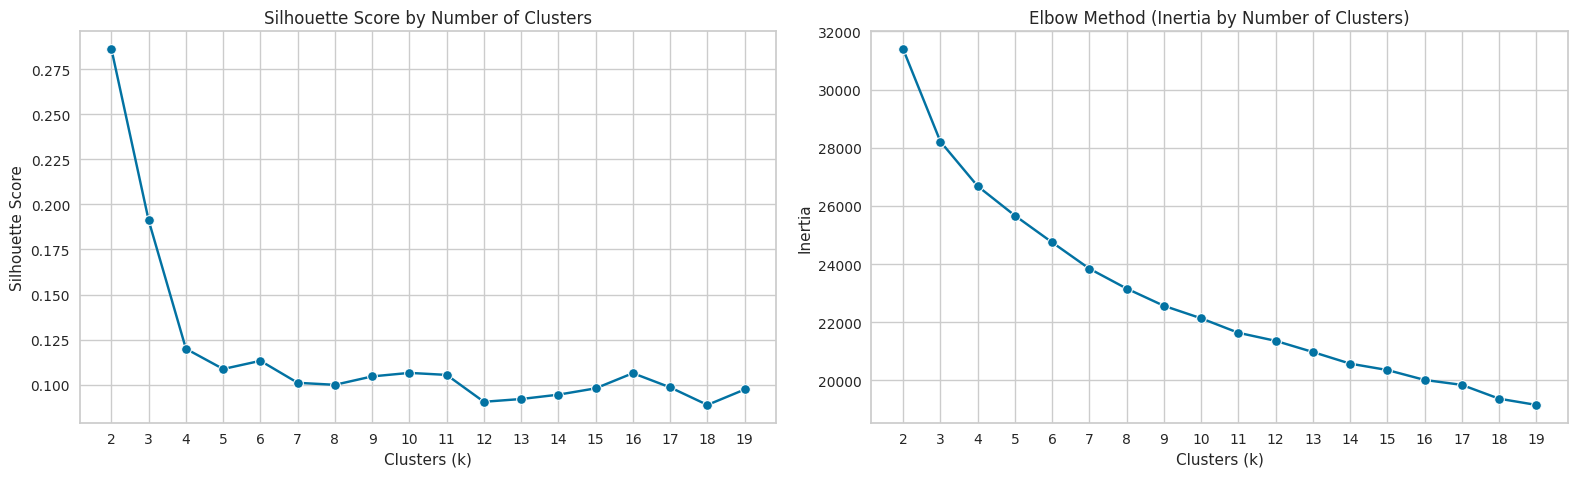

In [57]:
# Silhouette Score & Inertia (Elbow Method)

display(Markdown("## Silhouette Score & Inertia Plot"))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.set_style("whitegrid")

# Silhouette Score Plot
sns.lineplot(
    x=list(cluster_nums),
    y=silhouette_scores,
    marker="o",
    ax=axes[0]
)
axes[0].set_title("Silhouette Score by Number of Clusters")
axes[0].set_xlabel("Clusters (k)")
axes[0].set_ylabel("Silhouette Score")
axes[0].set_xticks(list(cluster_nums))

# Inertia Plot
sns.lineplot(
    x=list(cluster_nums),
    y=inertias,
    marker="o",
    ax=axes[1]
)
axes[1].set_title("Elbow Method (Inertia by Number of Clusters)")
axes[1].set_xlabel("Clusters (k)")
axes[1].set_ylabel("Inertia")
axes[1].set_xticks(list(cluster_nums))

plt.tight_layout()
plt.show()


Although the 2-cluster solution produces the highest average silhouette score, this still does not guarantee that it is the best choice. An individual clusters may still contain:

1. poorly separated samples
2. overlapping regions
3. points assigned to the wrong cluster.

To validate whether a cluster count is meaningful, we must inspect the distribution of silhouette values for each sample. This will allows us to see whether some clusters contain many low or negative silhouette values, which would indicate poor structure—even if the overall average score appears strong

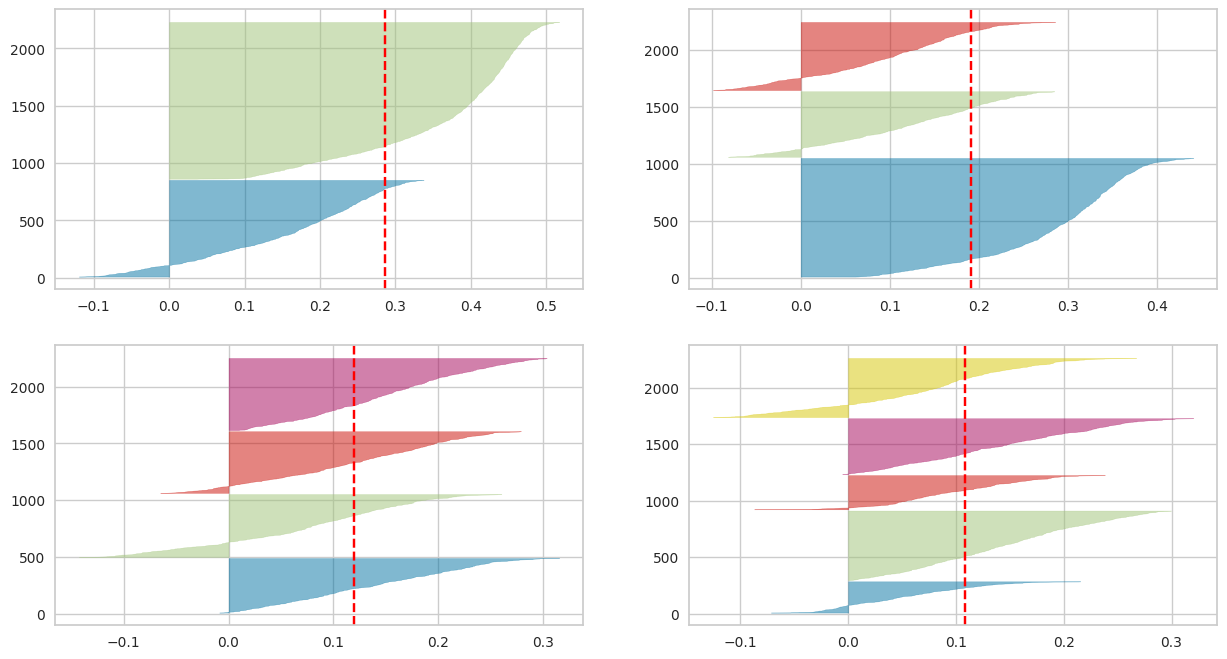

In [54]:
# Silhouette Analysis for Multiple Cluster Sizes

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    km = KMeans(n_clusters=i, n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(scaled_customers)

**Selection Criteria**
1. Silhouette Score Above the Average -
For each value of k, we look for clusters whose silhouette scores are consistently above the overall mean (red reference line)

2. Balanced Cluster Sizes
A good clustering solution should not produce one very large cluster and several very small ones. Large fluctuations in cluster size.

**Conclusion**:

1. Based on these criteria, the 3-cluster model provides the best balance of separation quality and stability. Therefore, we proceed by training the model using k = 3

2. A few points still appear misclassified, which may suggest underlying non-linear patterns that K-Means cannot capture due to its linear boundaries. As a next step, we can explore non-linear approaches—such as projecting the data into a higher-dimensional space using Gaussian or polynomial kernels—or evaluate more flexible algorithms like DBSCAN or Spectral Clustering

In [55]:
kmeans_3clusters = KMeans(n_clusters=3, random_state=0, n_init=10)
kmeans_3clusters.fit(scaled_customers)

KMeans(n_clusters=3, n_init=10, random_state=0)

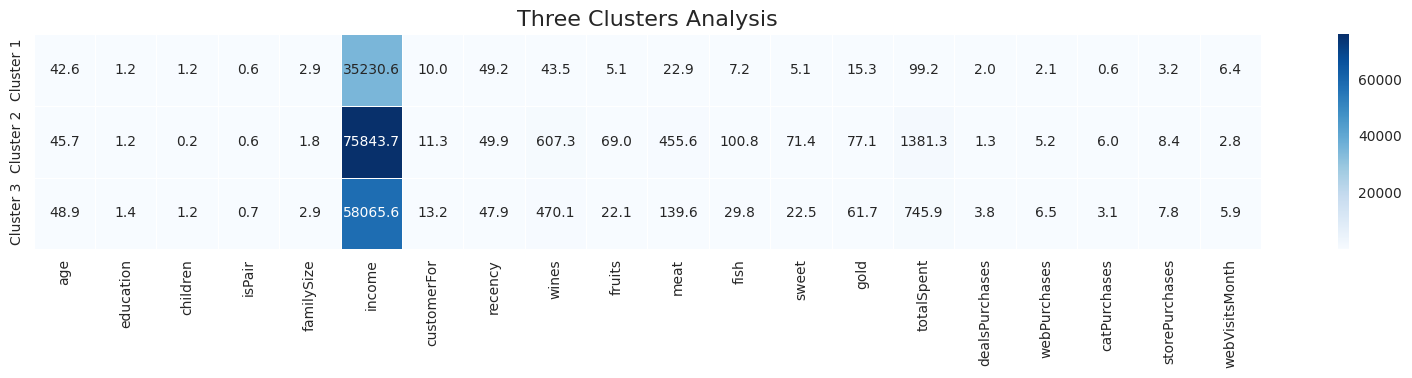

In [58]:
plt.figure(figsize=(16, 4))
plt.title("Three Clusters Analysis", fontsize=16)

cluster_centers = scaler.inverse_transform(kmeans_3clusters.cluster_centers_)

sns.heatmap(
    cluster_centers,
    annot=True,
    fmt=".1f",
    annot_kws={"size": 10},
    cmap="Blues",
    linewidths=0.5,
    yticklabels=["Cluster 1", "Cluster 2", "Cluster 3"],
    xticklabels=scaled_customers.columns
)

plt.tight_layout()
plt.show()


**Cluster Interpretation**


**Cluster 1 — Low Value Segment
Profile**
1. Lowest income among all clusters
2. Typically has one child
3. Purchases very few products across all categories
4. High website visit frequency, but very low online purchasing activity


**Business Insight**
This group represents low-value customers with minimal spending. They visit the website frequently, yet make very few purchases and show little product engagement.



**Cluster 2 — High Value Segment
Profile**
1. Highest income across all clusters
2. Few or no children
3. Highest spending across all product categories (wine, fruits, meat, fish, sweets, gold)
4. Rarely purchases through discounts or deals
5. Prefers store, catalog, and web purchases — in that order


**Business Insight**

This is the most profitable segment and should be the primary focus for the grocery retailer. These customers have strong purchasing power, shop across multiple channels, and buy variety of products.The main channel to focus are store and catalog, respectively. They also buy a lot on the web, but do not visit much the web page, so this is secondary focus. These customers have high income, so it is not a problem to show expensive products for them.


**Cluster 3 — Medium Value, Deal-Seeking Segment
Profile**
1. Mid-range income
2. Typically has one child
3. Purchases a wide range of products, though less than Cluster 2
4. Strong preference for using deals and discounts
5. Frequent website visitors, with high online purchasing activity
6. Moderate store purchases


**Business Insight**

This cluster represents a secondary but valuable segment. They respond well to discounts and promotional campaigns and tend to engage online. Digital promotions, targeted offers, and mid-priced product recommendations will resonate with this cluster.